# 语音信号分析
  语音信号分析是语音信号处理的前提和基础，只有分析出可表示语音信号本质特征的参数，才有可能利用这些参数进行高效的语音识别。因此语音信号分析在语音信号处理应用中具有举足轻重的地位。
  贯穿于语音分析全过程的是短时分析技术，因为语音信号从整体来看其特性及表征其本质特性的参数都是随时间而变化的，所以它是一个非平稳过程，不能使用处理平稳信号的数字信号处理技术对其进行分析处理。但是，由于不同的语音是人的口腔肌肉运动构成声道的某种形状而产生的响应，而这种口腔肌肉运动相对于语音频率来说是非常缓慢的，所以从另一方面看，虽然语音信号具有时变特性，但是在一个较短的时间范围内（一般认为在10-30ms），其特性基本保持不变即相对稳定，因而可以将其看作是一个准稳态过程，即语音信号具有短时平稳性，所以任何语音信号的分析和处理必须建立在“短时”的基础上，即进行短时分析，将语音信号分为一段一段来分析其特征参数，其中每一段称为一帧，帧长一般取为10-30ms。

## 预处理
实际的语音信号是模拟信号，因此在语音信号进行数字处理之前，首先要将模拟信号按照一定的采样频率$f_{s}$进行离散化，使用的采样频率$f_{s}$选取应根据模拟语音信号的宽带(奈奎斯特采样定理)来确定，以避免信号的频域混叠失真，语音信号的频率范围通常是300Hz~3400Hz，一般情况下采样频率$f_{s}$为8kHz即可。对离散化后语音信号进行量化处理，此过程会带来一定的量化噪声和失真，量化位数一般都是8bit或者16bit。所以对于语音信号比较重要的两个参数就是采样频率$f_{s}$和量化位数。


_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=85392, comptype='NONE', compname='not compressed')


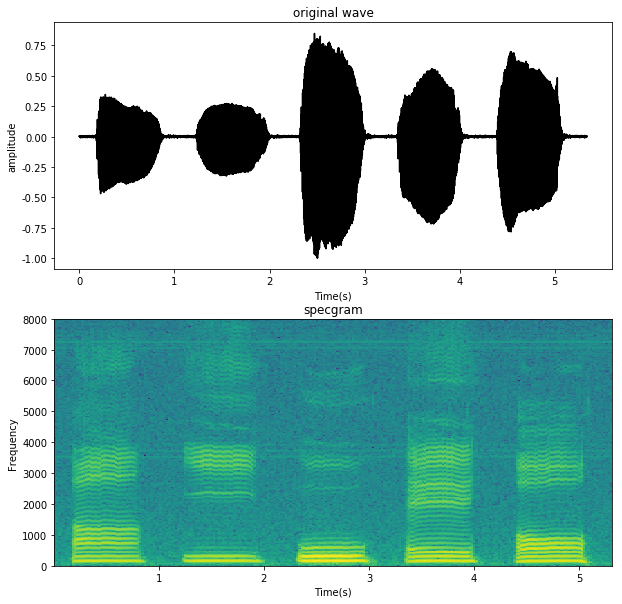

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import wave
%matplotlib inline


wavfile = os.path.join('.','aeiou.wav')
audio = wave.open(wavfile,'rb')
params = audio.getparams()
print(params)
# nchannels: 音频的通道数
# sampwidth：每个采样点的字节数
# framerate：采样率
# nframes： 音频采样点数
nchannels = audio.getnchannels()
sampwidth= audio.getsampwidth()
framerate = audio.getframerate()
nframes = audio.getnframes()
# nchannels, sampwidth, framerate, nframes = params[:4]
strData = audio.readframes(nframes)
waveData = np.frombuffer(strData, dtype=np.short)
waveData = waveData * 1.0/max(abs(waveData))

waveData = np.reshape(waveData, [nframes,nchannels]).T
audio.close()
# 绘制波形图
time = np.arange(0, nframes)*(1.0/framerate)
time = np.reshape(time, [nframes, 1]).T
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(time[0,:nframes], waveData[0, :nframes], c='black')
plt.xlabel('Time(s)')
plt.ylabel('amplitude')
plt.title('original wave')
#plt.show()

# 绘制语谱图
framelength = 0.025 # 帧长25ms
framesize = int(framelength*framerate)

nfftdict = {}
lists = [32, 64, 128, 256, 512, 1024]
for i in lists:
    nfftdict[i] = abs(framesize - i)
sortlist = sorted(nfftdict.items(), key=lambda x: x[1])
framesize = int(sortlist[0][0])


NFFT = framesize #NFFT必须与时域的点数framsize相等，即不补零的FFT
overlapSize = 1.0/3 * framesize #重叠部分采样点数overlapSize约为每帧点数的1/3~1/2
overlapSize = int(round(overlapSize))#取整
plt.subplot(2,1,2)
spectrum,freqs,ts,fig = plt.specgram(waveData[0],NFFT = NFFT,Fs =framerate,window=np.hanning(M = framesize),noverlap=overlapSize,mode='default',scale_by_freq=True,sides='default',scale='dB',xextent=None)#绘制频谱图         
plt.ylabel('Frequency')
plt.xlabel('Time(s)')
plt.title('specgram')
plt.show()

### 预加重
由于语音信号的平均功率谱受声门和口鼻辐射影响，高频端大约在800Hz以上按6dB/倍频程跌落，即6dB/oct(2倍频)或20dB/dec(10倍频)，所以需要对语音信号进行预加重，提升高频部分，使信号的频谱变得平坦，保持在低频到高频的整个频带中，从而削弱口唇辐射的影响。一般通过传递函数为$H(z) = 1-\alpha z^{-1}$的一阶FIR高通数字滤波器来实现预加重，其中$\alpha$为预加重系数，$0.9<\alpha<1.0$.设n时刻的语音采样值为x(n),经过预加重处理的结果$y(n)=x(n)-\alpha x(n-1)$, 这里的$\alpha=0.98$.

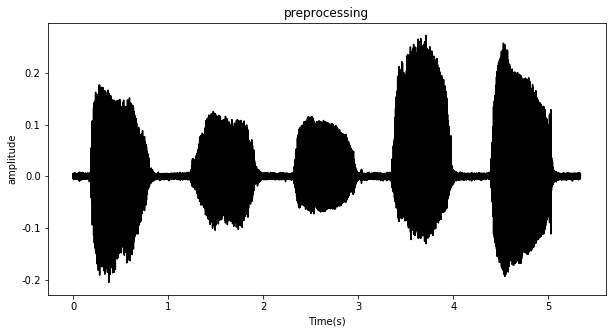

In [2]:
preaudio = np.zeros(waveData[0].shape)
preaudio[0] = waveData[0][0]
preaudio[1:] = waveData[0][1:] - 0.98*waveData[0][:-1]
plt.figure(figsize=(10,5))
plt.plot(time[0,:nframes], preaudio[:nframes], c='black')
plt.xlabel('Time(s)')
plt.ylabel('amplitude')
plt.title('preprocessing')
plt.show()


### 加窗分帧
进行预加重数字滤波处理后，接下来需要进行加窗分帧处理。语音信号是一种随时间变化的信号，主要分为浊音和清音两大类。浊音的基音周期，清浊音信号幅度和声道参数等都随时间而缓慢变化。由于发声器官的惯性运动，可以认为在一小段时间里（一般为10-30ms）语音信号近似不变，即语音信号具有短时平稳性，这样，可以把语音信号分成以一帧帧的语音片段（分析帧）来进行处理。语音信号的分帧是采用可滑动的有限长度的窗口进行加权的方法来实现的，窗长即为帧长，为了使帧与帧之间的平滑过渡，保持其连续性，帧之间存在重叠，称为帧移，帧移与帧长的比值一般取0~1/2.在语音信号数字处理中常用的窗函数是:

矩形窗：
$$w(n)=\begin{cases}
1, & 0\leq n\leq (N-1) \\
0, & else
\end{cases}$$

汉明窗：
$$w(n)=\begin{cases}
0.54-0.46\cos[\frac{2\pi n}{(N-1)}], & 0\leq n\leq N-1 \\
0, & else \end{cases}$$
对于窗函数选择而言，一般好的窗函数的标准是，在时域上是语音波形乘以窗函数，所以要减少时间窗两端的坡度，使窗口边缘两端不引起急剧变化而平滑过渡到零，这样可以使截取出的语音波形缓慢降为零，减少语音帧的截断效应，在频域要有较宽的3dB带宽以及较小的边带最大值。

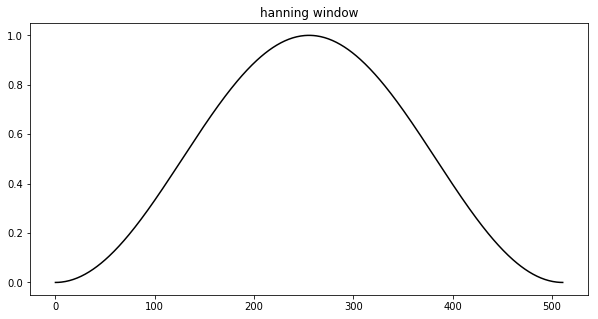

In [3]:
plt.figure(figsize=(10,5))
plt.plot(np.hanning(512),c='black')
plt.title('hanning window')
plt.show()

In [4]:
def enframe(signal, nw, inc, winfunc):
    '''
    signal:波形
    nw: 帧长
    inc:帧移
    '''
    signal_length=len(signal)
    if signal_length<=nw:
        nf=1
    else: #否则，计算帧的总长度
        nf=int(np.ceil((1.0*signal_length-nw+inc)/inc))
    pad_length=int((nf-1)*inc+nw) #所有帧加起来总的铺平后的长度
    zeros=np.zeros((pad_length-signal_length,)) #不够的长度使用0填补，类似于FFT中的扩充数组操作
    pad_signal=np.concatenate((signal,zeros)) #填补后的信号记为pad_signal
    indices=np.tile(np.arange(0,nw),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(nw,1)).T  #相当于对所有帧的时间点进行抽取，得到nf*nw长度的矩阵
    indices=np.array(indices,dtype=np.int32) #将indices转化为矩阵
    frames=pad_signal[indices] #得到帧信号
    win=np.tile(winfunc(nw),(nf,1))  #window窗函数，这里默认取1
    return frames*win   #返回帧矩阵
# 帧长25ms，帧移10ms
framesize = int(0.025*framerate)
frameshift = int(0.01*framerate)
framesData = enframe(preaudio, framesize, frameshift, np.hanning)
print(framesData.shape)


(533, 400)


## 时域分析
语音信号的时域分析就是分析和提取语音信号的时域参数。 进行语音分析时，最先接触到并且也是最直观的是它的时域波形。语音信号的时域参数有短时能量、短时过零率、短时自相关函数和短时平均幅度差函数，这是语音信号的一组最基本的短时参数。

### 短时能量以及短时平均幅度分析
设语音波形时域信号为$x(l)$,加窗分帧处理后得到的第n帧语音信号为$x_{n}(m)$,则$x_{n}(m)$满足下式：

$$x_{n}(m)=w(m)x(n+m), 0\leq m\leq N-1$$
$$w(n)=\begin{cases}
1, & m=0~(N-1) \\
0, & else\end{cases}$$
其中，$n=0,1T,2T,...$, 并且$N$为帧长，$T$为帧移长度。
设第n帧语音信号$x_{n}(m)$的短时能量用$E_{n}$, 则其计算公式如下：
$$ E_{n} = \sum_{m=0}^{N-1}x_{n}^{2}(m)$$
$E_{n}$是一个度量语音信号幅度值变化的函数，对高电平比较敏感，因此可以使用短时平均幅度函数$M_{n}$,定义为：
$$ M_{n}=\sum_{m=0}^{N-1}|x_{n}(m)$$
使用短时能量以及短时平均幅度主要是可以区分浊音和清音段，因为浊音的能量比清音的能量大，也可以区分有声与无声，此外还可以作为一维特征，用于语音识别

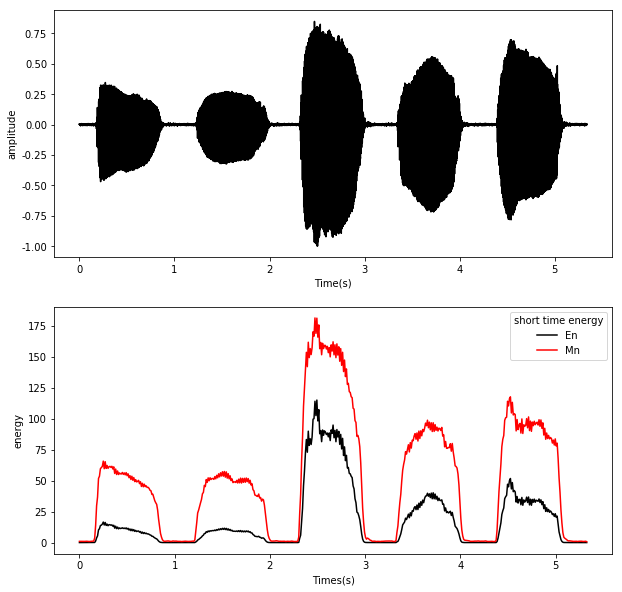

In [5]:
framesData = enframe(waveData[0], framesize, frameshift, np.ones)
En = np.sum(np.square(framesData), axis=1)
Mn = np.sum(abs(framesData), axis=1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(time[0],waveData[0], c='black')
plt.xlabel('Time(s)')
plt.ylabel('amplitude')
plt.subplot(2,1,2)
time2 = np.arange(0,len(En))*(len(waveData[0])/len(En) / framerate)
plt.plot(time2, En, c='black', label='En')
plt.plot(time2, Mn, c='red', label='Mn')
plt.xlabel('Times(s)')
plt.ylabel('energy')
plt.legend(title="short time energy") 
plt.show()

### 短时过零率
短时过零率表示一帧语音中语音波形穿越横轴的次数，过零率分析是短时分析中最简单的一种。对于离散信号，如果相邻的采样值改变符号则称为过零。定义语音信号
$x_{n}(m)$的短时过零率$Z_{n}$为：
$$Z_{n}=\frac{1}{2}\sum_{m=0}^{N-1}|sgn[x_{n}(m)]-sgn[x_{n}(m-1)]|$$

<function matplotlib.pyplot.show(*args, **kw)>

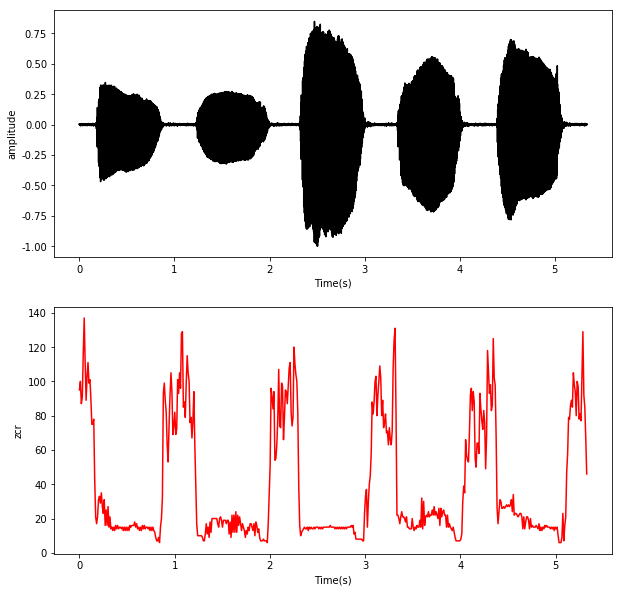

In [6]:
nframes = framesData.shape[0]
zcr = np.zeros((nframes,1))
for i in range(nframes):
    curframe = framesData[i]
    curframe = curframe - np.mean(curframe)
    zcr[i] = sum(curframe[:-1]*curframe[1:] <=0) 

time = np.arange(0, len(waveData[0])) * (1.0 / framerate)
time2 = np.arange(0, len(zcr))*(len(waveData[0])/len(zcr) / framerate)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(time,waveData[0], c='black')
plt.xlabel('Time(s)')
plt.ylabel('amplitude')
plt.subplot(2,1,2)
plt.plot(time2,zcr,c='red')
plt.xlabel('Time(s)')
plt.ylabel('zcr')
plt.show

### 短时相关分析
相关分析是一种常见的时域波形分析方法，有自相关和互相关之分，这里主要讨论是自相关。自相关函数有一些性质，比如它是偶函数，假设序列是偶函数，则自相关函数也是同周期的函数，利用这些性质，可以计算浊音的基音周期。在语音波形信号中，我们分析的是短时自相关函数。定义语音信号$x_{n}(m)$的短时自相关函数$R_{n}(k)$的计算式如下：
$$R_{n}(k) = \sum_{m=0}^{N-1-k}x_{n}(m)x_{n}(m+k), (0\leq k\leq K)$$

考虑当k值变大，参与计算自相关的采样点越来越少，这样计算出的ACF也越来越小，修正自相关函数：
$$ \hat R_{n}(k) = \sum_{m=0}^{N-1-k}x_{n}(m)x^{'}(m+k)$$
其中：
$$ x_{n}(m) = w(m)x(n+m), 0\leq m \leq N-1$$
$$ x^{'}(m) = w(m)x(n+m), 0\leq m \leq N-1+k$$

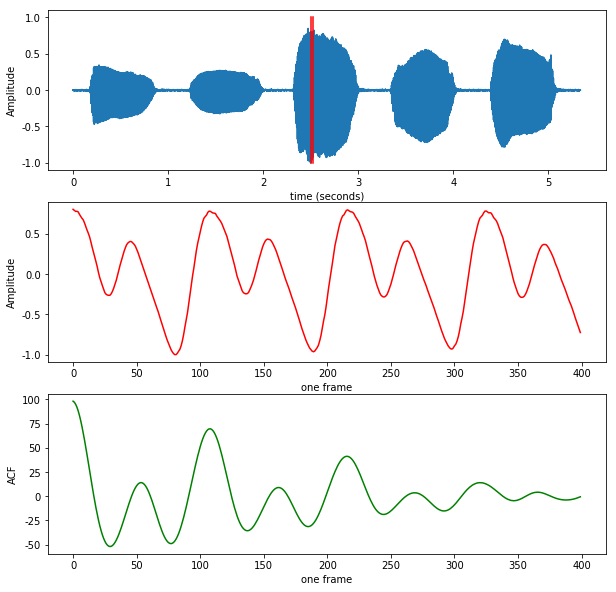

In [7]:
def ACF(frame):
    flen = len(frame)
    acf = np.zeros(flen)
    for i in range(flen):
        acf[i] = np.sum(frame[i:flen]*frame[0:flen-i])
    return acf

idx1 = 40000
idx2 = idx1+framesize
index1 = idx1*1.0 / framerate
index2 = idx2*1.0 / framerate
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(time, waveData[0])
plt.plot([index1,index1],[-1,1],'r')
plt.plot([index2,index2],[-1,1],'r')
plt.xlabel("time (seconds)")
plt.ylabel("Amplitude")
plt.subplot(3,1,2)
plt.plot(np.arange(framesize),waveData[0][idx1:idx2],'r')
plt.xlabel("one frame")
plt.ylabel("Amplitude")
plt.subplot(3,1,3)
plt.plot(np.arange(framesize),ACF(waveData[0][idx1:idx2]),'g')
plt.xlabel("one frame")
plt.ylabel("ACF")
plt.show()

从上面ACF分析可知，第二个波峰的位置对应就是的基音(pitch)的位置，从而可以计算得到基音周期。

### 短时平均幅度差函数
短时自相关函数是语音信号时域分析的重要方法，但是，其计算量比较大，其原因是乘法运算时间比较长，为了避免乘法运算，一个简单的方法就是利用差值。平均幅度差函数能够代替自相关函数进行语音分析，是基于以下事实：如果信号是完全的周期函数则相距为周期的整数倍的采样点的幅值是相同的，差值为零。所以可定义短时平均幅度差函数为：
$$F_{n}(k) = \sum_{m=0}^{N-1-k}|x_{n}(m) - x_{n}(m+k)|$$


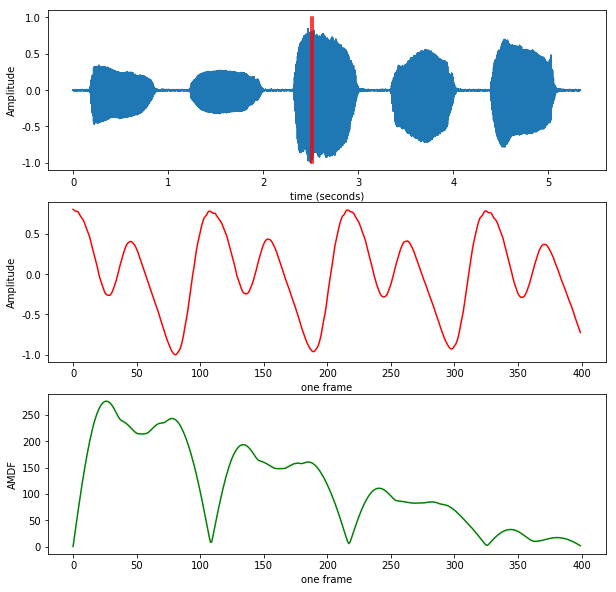

In [8]:
def AMDF(frame):
    flen = len(frame)
    amdf = np.zeros(flen)
    for i in range(flen):
        amdf[i] = np.sum(abs(frame[i:flen]-frame[0:flen-i]))
    return amdf

idx1 = 40000
idx2 = idx1+framesize
index1 = idx1*1.0 / framerate
index2 = idx2*1.0 / framerate
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(time, waveData[0])
plt.plot([index1,index1],[-1,1],'r')
plt.plot([index2,index2],[-1,1],'r')
plt.xlabel("time (seconds)")
plt.ylabel("Amplitude")
plt.subplot(3,1,2)
plt.plot(np.arange(framesize),waveData[0][idx1:idx2],'r')
plt.xlabel("one frame")
plt.ylabel("Amplitude")
plt.subplot(3,1,3)
plt.plot(np.arange(framesize),AMDF(waveData[0][idx1:idx2]),'g')
plt.xlabel("one frame")
plt.ylabel("AMDF")
plt.show()

从上图可以看出，AMDF在浊音的基音周期上会出现最小值，对比ACF，运算简单，且更有效果，已被用在许多实时语音处理系统中。
## 频域分析
语音信号的频域分析就是分析语音信号的频率特征，从广义上讲，语音信号的频域分析包括语音信号的频谱、功率谱、倒频谱、频谱包络分析等，而常用的频域分析方法有带通滤波器组法，傅里叶变化法等，这里重点介绍傅里叶分析法，因为语音波形是一个非平稳过程，因此适用于周期，瞬变或平稳随机信号的标准傅里叶变化不能用来直接表示语音信号，而是用短时傅里叶变换队语音信号的频谱进行分析，相应的频谱称为短时谱。

这里说明一下使用FFT的一个概念：频率分辨率，可理解为在使用DFT时，在频率轴上的所得到的最小频率间隔 $f_{0} = \frac{fs}{N}=\frac{1}{NTs}=\frac{1}{T}$,其中N为采样点数，$fs$为采样频率，$Ts$为采样周期，所以$NTs$就是采样前模拟信号的时间长度T，所以信号长度越长，频率分辨率越好，那么采样点数越多，频率分辨率相应就提高呢？其实不是的，因为一段数据进行变换前就确定了时间$T$,注意$f_{0}=\frac{1}{T}$, 而$T=NTs$,增加$N$必然减少$Ts$,因此增加$N$时,$f_{0}$是不变的，因此只有增加采样点的同时增加数据长度$T$才能使频率分辨率越好。此外，在FFT时候，经常会在有效数据后面补零达到对频谱的改善，通常认为这是增加了$N$,从而使频率分辨率变好了，其实补零并没有增加有效数据的长度，仍然为$T$,但补零有其他的好处，第一，使数据$N$为2的整数幂，便于使用FFT; 第二，补零后，是对FFT结果做了插值，克服“栅栏”效应，使谱更加平滑，可以把"栅栏"效应理解为，就像站在栅栏旁边透过栅栏看外面风景，肯定有被栅栏挡住比较多风景，此时就可能漏掉比较大频域分量，但是补零后，相当于你站远了，改变了栅栏密度，风景就看的越来越清楚了;第三，由于对数据的截断必然会造成频谱泄露，因此在频谱中可能出现难以辨认的谱峰，补零在一定程度上能消除此种现象。

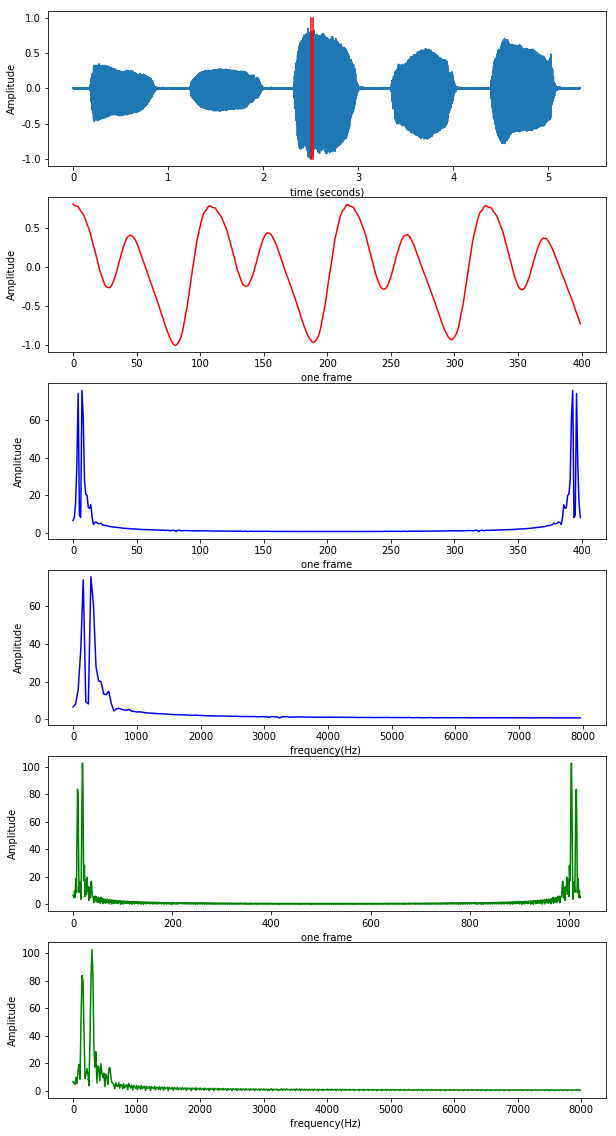

In [9]:
from scipy.fftpack import fft,ifft

idx1 = 40000
idx2 = idx1+framesize
index1 = idx1*1.0 / framerate
index2 = idx2*1.0 / framerate
plt.figure(figsize=(10,20))
plt.subplot(6,1,1)
plt.plot(time, waveData[0])
plt.plot([index1,index1],[-1,1],'r')
plt.plot([index2,index2],[-1,1],'r')
plt.xlabel("time (seconds)")
plt.ylabel("Amplitude")
plt.subplot(6,1,2)
plt.plot(np.arange(framesize),waveData[0][idx1:idx2],'r')
plt.xlabel("one frame")
plt.ylabel("Amplitude")
# 使用framesize个点的FFT
plt.subplot(6,1,3)
# 频率分辨率
df = framerate/framesize
plt.plot(np.arange(framesize), abs(fft(waveData[0][idx1:idx2])), 'b')
plt.xlabel("one frame")
plt.ylabel("Amplitude")
plt.subplot(6,1,4)
plt.plot(np.arange(framesize/2)*df, abs(fft(waveData[0][idx1:idx2]))[:int(framesize/2)],'b')
plt.xlabel("frequency(Hz) ")
plt.ylabel("Amplitude")
plt.subplot(6,1,5)
# 使用1024个点，不足进行补零操作
# 频率分辨率
df2 = framerate/1024
plt.plot(np.arange(1024), abs(fft(waveData[0][idx1:idx2],1024)), 'g')
plt.xlabel("one frame")
plt.ylabel("Amplitude")
plt.subplot(6,1,6)
plt.plot(np.arange(1024/2)*df2, abs(fft(waveData[0][idx1:idx2],1024))[:512],'g')
plt.xlabel("frequency(Hz) ")
plt.ylabel("Amplitude")
plt.show()

从上面的可以看到，图三与图五进行fft的点数不同，所以频率分辨率不同，补零只是进行了插值操作，使频谱变得平滑，但都是关于$fs/2$或者$N/2$对称,，实际使用中，只取前半部分即可作为信号的频谱,如图四和图六所示。

## 倒谱分析
语音信号的倒谱分析就是求取语音倒谱特征参数的过程，它可以使用同态处理来处理，同态信号处理也称为同态滤波，它实现了将卷积关系变换为求和的关系的分离处理，即解卷。对语音信号进行解卷，可将语音信号的声门激励信息以及声道相响应信息分离开来，从而求得声道共振峰特征和基音周期，除此之外还可以用在机械故障诊断相关的，如齿轮箱分析。

一个信号的倒谱定义为信号频谱模的自然对数的逆傅里叶变换，设信号为$s(n)$,则其倒谱为：

$$ \hat s(n) = IDFT[ln|DFT[s(n)]|]$$
根据语音信号产生模型，语音信号$s(n)$是由声门脉冲激励$e(n)$经声道相应$v(n)$滤波而得到的，即：
$$ s(n) = e(n)*v(n)$$
设三者的倒谱分别为$\hat s(n),\hat e(n),\hat v(n)$,则有：
$$\hat s(n) = \hat e(n) + \hat v(n)$$
在倒谱域中,基音信息与声道信息可以认为是相对分离的，因为两者的频率范围是不同的，这样只要简单采用的倒滤波方法皆可以分离并恢复出$e(n)$和$v(n)$, 并求出基音周期。

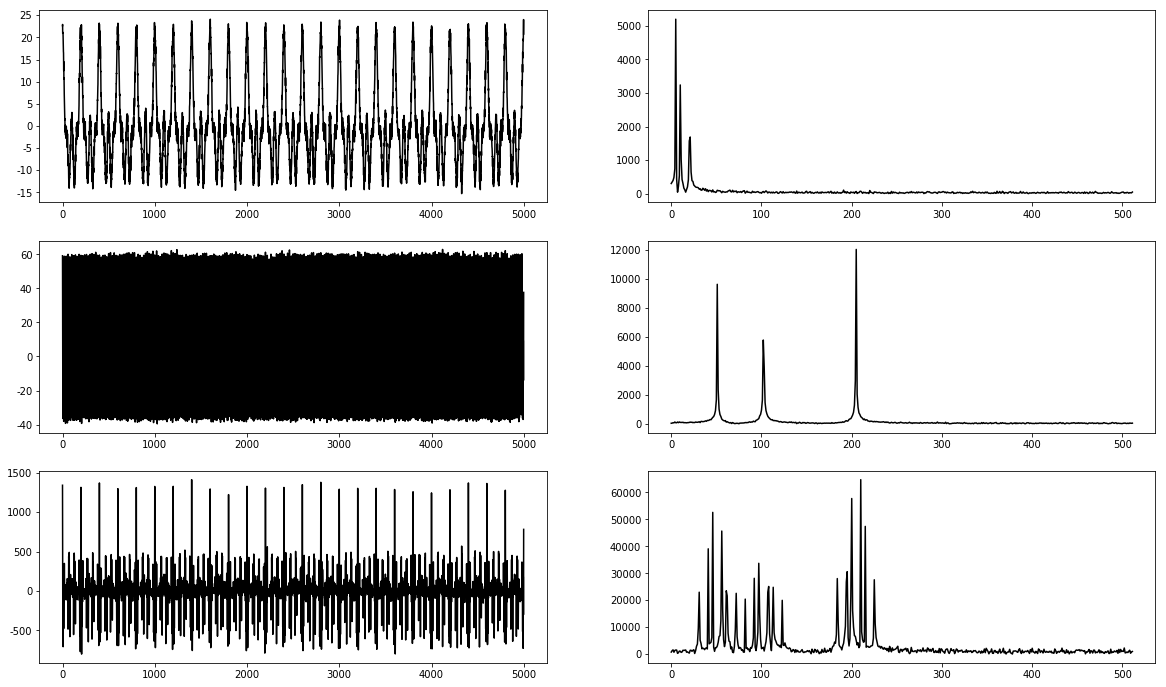

In [17]:
fs = 1000
nfft = 1024
t = np.arange(0, 5, 1/fs)
#y1 = 10*np.cos(2*np.pi*t)
#y2 = 15*np.cos(2*np.pi*10*t)
y1 = 10*np.cos(2*np.pi*5*t) + 7*np.cos(2*np.pi*10*t) + 5*np.cos(2*np.pi*20*t) + np.random.randn(t.size)
y2 = 20*np.cos(2*np.pi*50*t) + 15*np.cos(2*np.pi*100*t) + 25*np.cos(2*np.pi*200*t) + np.random.randn(t.size)
y = y1*y2

Y1 = fft(y1,nfft)
Y1 = np.abs(Y1)

Y2 = fft(y2, nfft)
Y2 = np.abs(Y2)

Y = fft(y, nfft)
Y = np.abs(Y)

# 计算倒谱
spectrum = fft(y, nfft)
ceps = ifft(np.log(np.abs(spectrum))).real

plt.figure(figsize=(20,12))
plt.subplot(321)
plt.plot(y1,c='black')

plt.subplot(322)
plt.plot(Y1[:nfft//2],c='black')

plt.subplot(323)
plt.plot(y2,c='black')

plt.subplot(324)
plt.plot(Y2[:nfft//2],c='black')

plt.subplot(325)
plt.plot(y,c='black')

plt.subplot(326)
plt.plot(Y[:nfft//2],c='black')

plt.show()

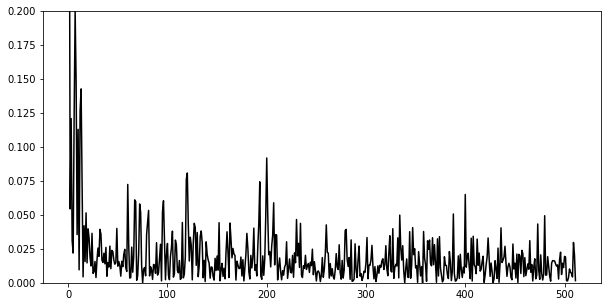

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(np.abs(ceps)[:nfft//2],c='black')
plt.ylim([0,0.2])
plt.show()